In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
from scipy.linalg import block_diag
import random
import matplotlib.pyplot as plt
from math import pi, sqrt
import time

In [2]:
def initialize_wf(n,n_e):
    n_loc=np.zeros((n,),dtype= 'int')        
    config=np.sort(random.sample(range(n),n_e))
    n_loc[config]=np.ones((n_e,))
    n_ind = np.zeros((n,),dtype=int)        
    n_ind[config] = np.arange(1,n_e+1)
    
    return n_loc, config, n_ind

In [3]:
def wf_gen(n,n_e,BC,t1,t2):
    h1=np.ones(n-1)
    h1[0::2]=0
    h2=np.ones(n-1)
    h2[1::2]=0
    hop= np.diag(t1*h1+t2*h2+0j,1)
    hop[n-1,0]= t1*BC
    H_t= -(hop+ np.matrix(hop).H)/2 
    energies, evecs= np.linalg.eigh(H_t)
    return evecs[:,:n_e]

def WF_MAT(wf_gen, config):
    n_e = len(config)
    wf = np.zeros((n_e,n_e),dtype = "complex")
    wf = np.transpose(wf_gen[config,:])
     
    return wf

In [4]:
def exact_renyi_calc(r,GA,epsilon=1e-9):
    chi0, _ =np.linalg.eigh(GA)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)] #/np.sum(chi1[np.nonzero(np.abs(chi1-1)>epsilon)])
    return np.sum(np.log((1-chi2)**r+chi2**r))/(1-r) #np.sum(np.log((1-chi2)**r+chi2**r))/(1-r) #Twice as large....
    #return np.log(np.sum(chi2**r))/(1-r) 

In [7]:
from itertools import combinations

def binseq(k):
    L = np.zeros(2,dtype='int')
    L[1]=1
    empt = np.zeros(0,dtype='int')
    return [np.append(empt,x) for x in itertools.product(L, repeat=k)]

def exact_negativity_calc(r,N,N_e,orbitals,n_l,n_t,epsilon=1e-9):
    
    ind_a = np.arange(2**(N-n_l),dtype='int')     #indicies for sites to be transposed
    ind_list = 2*np.ones(N,dtype='int')           #Indicies for all states
    ind_list_R = 2*np.ones(n_l,dtype='int')       #Indicies for states in reduced density matrix
    Den = np.zeros(ind_list,dtype = 'complex')

    bin_t = 2**n_t                                #Size of subspace to be transposed
    bin_l = 2**n_l                                #Size of reduced hilbert space

    N_loc = np.zeros(N,dtype='int')

    Configs = combinations(np.arange(N), N_e)     #All configurations with N_e occupied sites
    l = list(Configs)
    n = len(l)
    wfs = np.zeros((n,n),dtype='complex' )
    state = np.zeros(n,dtype= 'complex')
    count = 0
    D= np.zeros((2**N,2**N),dtype='complex')
    D_R= np.zeros((2**n_l,2**n_l),dtype='complex')
    D_f= np.zeros((2**n_l,2**n_l),dtype='complex')
    
    for i in l: 
        wf = WF_MAT(orbitals, i)
        state[count] = np.linalg.det(wf)

        I=np.array(i)
        N_loc = np.zeros(N,dtype='int')
        N_loc[I] = np.ones(N_e)
        Den[tuple(N_loc)] =  state[count]

        count+=1
    
    base = Den.T.reshape(2**N,)   #Transpose puts basis in correct order
    ll = np.int(2**N)
    D= np.outer(base,np.matrix(base).H)          #Full density matrix
    
    t_A = np.zeros(bin_l,dtype ='int')
    t_B = np.zeros(bin_l,dtype ='int')
    phi = np.zeros(D_f.shape,dtype = 'complex')
    for point in range(bin_l):
        t_A[point] = np.sum(np.asarray(tuple(bin(point))[2:],dtype = "int")[::-1][0:n_t])   #occupation in region A
        t_B[point] = np.sum(np.asarray(tuple(bin(point))[2:],dtype = "int")[::-1][2:])      #occupation in region B
    for cc in range(bin_l):
        for CC in range(bin_l):
            D_R[cc,CC]=np.trace(D[np.ix_(cc+bin_l*ind_a,CC+bin_l*ind_a)])
            phi[cc,CC] = (-1)**(int(t_A[cc]+t_A[CC])%2/2+int((t_A[cc]+t_A[CC])*(t_B[cc]+t_B[CC])))  #Fermion phase
            D_f[cc,CC]= D_R[cc,CC]*phi[cc,CC]

        
    D_R_T = np.copy(D_R)
    D_f_T = np.copy(D_f)
    ind_c = np.arange(2**(n_l-n_t),dtype='int')
    lp = bin_t
    p=np.int(bin_l/lp)
    for count1 in range(lp): 
        for count2 in range(lp): 
            D_R_T[np.ix_(count1+bin_t*ind_c,count2+bin_t*ind_c)] = D_R_T[np.ix_(count1+bin_t*ind_c,count2+bin_t*ind_c)].T
            D_f_T[np.ix_(count1+bin_t*ind_c,count2+bin_t*ind_c)] = D_f_T[np.ix_(count1+bin_t*ind_c,count2+bin_t*ind_c)].T
        
    eig_D_R, _ =np.linalg.eigh(D_R)
    eD_R=eig_D_R[np.nonzero(np.abs(eig_D_R)>epsilon)]
    
    eig_D_R_T, _ =np.linalg.eigh(D_R_T)
    eDRT=eig_D_R_T[np.nonzero(np.abs(eig_D_R_T)>epsilon)]
    
    result = 0
    if r==1:
        result = np.log(np.linalg.norm(D_f_T,'nuc'))
    elif r%2 == 1:
        #result = np.log((np.sum(np.abs(eDRT**r))))/(1-r) #/(np.sum(eD_R**r))
        result = np.log(np.trace(np.dot(np.linalg.matrix_power(np.dot(D_f_T,np.matrix(D_f_T).H),int(r/2)),D_f_T)))/(1-r)
    else:
        #result = np.log((np.sum(np.abs(eDRT**r)))/(np.sum(eD_R**r)))/(2-r)
        result = np.log(np.trace(np.linalg.matrix_power(np.dot(D_f_T,np.matrix(D_f_T).H),int(r/2))))/(1-r)
        
    return(result)

In [9]:
def exact_Renyi_neg_calc(r,N,Na,Nb,V1,epsilon=1e-9):
    '''computes moments of partial transpose tr(\rho^T \rho^T\dag ... )
    for 1d free fermions ''' 
    k_sw=np.arange((-(r-1)/2),(r-1)/2+0.1,1)
    Zk=0
    if (r % 2) == 0:
        delta=pi
    else:
        delta= pi*(r-1)/r
#     delta=pi

    Nflip=Na+Nb
    N1=int((N-Nflip)/2)

    for i_k in range(len(k_sw)):
        op_k=block_diag(np.eye(N1),np.exp(1j*2*pi/r*k_sw[i_k])*np.eye(Na),np.exp(1j*delta-1j*2*pi/r*k_sw[i_k])*np.eye(Nb),np.eye(N1))
        Zk +=np.real(np.log( np.linalg.det( np.dot(np.dot(np.matrix(V1).H,op_k),V1) )))
    return Zk

In [10]:
r = 3
t=1
dt=0
n = 10
n_e = int(n/2)
Orbitals = wf_gen(10,5,-1,t+dt,t-dt)
print(exact_negativity_calc(r,10,5,Orbitals,4,3,epsilon=1e-9), 'r = ',r)
print(exact_Renyi_neg_calc(r,10,3,1,Orbitals,epsilon=1e-9)/(1-r), 'r = ',r)

(1.083814260690783+6.019621049604893e-17j) r =  3
1.0231628277496378 r =  3


In [36]:
def run_negativity(Orbitals, wf_r, config_r, n_loc_r, n_ind_r,n, n_e, n_configs, check_step,t,BC, inds_A,inds_A1,inds_A2):
    
    move_attempted=0.0
    move_accepted=0.0
    i_up = (np.arange(r)+1)%r
    i_down = (np.arange(r)-1)%r
    
    min_state = 2

    E_t=np.zeros(n_configs,dtype=complex)  
    rel= np.zeros(((n_configs+min_state)*(check_step),n_e),dtype=complex)
    
    n_inside_A_0 = np.sum(n_loc_r[inds_A,0],axis = 0)
    wf_inds= np.zeros((n_inside_A_0,r),dtype=int)
    wf_inv_r = np.zeros(wf_r.shape,dtype=np.complex128)
    wf_det = np.zeros(r,dtype=np.complex128)
    for i_r in range(r):
        wf_inv_r[:,:,i_r]=np.linalg.inv(wf_r[:,:,i_r])
        wf_det[i_r] =np.linalg.det(wf_r[:,:,i_r])
        #pt_num_inside = np.argwhere( n_loc_r[inds_A,i_r]>0 )
        #pt_num_inside = np.reshape( pt_num_inside, (len(pt_num_inside),)).tolist()
        #wf_inds[:,i_r]=( n_ind_r[ inds_A[pt_num_inside], i_r] )-1   #Used to be sorted
        
    #wf_sw = np.zeros(wf_r.shape,dtype=np.complex128)
    #up_one = (np.arange(r)+1)%r
    #for i_r in range(r):
    # r permutation of subsystem indices
    #    wf_sw[:,:,i_r] = np.copy(wf_r[:,:,i_r])
    #    wf_sw[:,wf_inds[:,i_r],i_r] = np.copy(wf_r[:,wf_inds[:,up_one[i_r]],up_one[i_r]])

    
    count=0      # counter for energy
    count_neg=0  #counter for negativity
    ent_ratio=np.zeros(n_configs*check_step,dtype= np.complex128)
    neg_ratio=np.zeros(n_configs*check_step,dtype= np.complex128)

    step_abs=np.arange(1,n_hop+1) #possible steps of random walk
    step_vals=np.sort(np.concatenate((-step_abs,step_abs),axis=0)).tolist() #Makes a list of steps from -n_hop to n_hop

    for state in range(0,n_configs+min_state):                              #Number of measurements
        for step in range(0,check_step):                               #Number of steps before measurement

            for i_r in range(r):
                for moved_e in range(0,n_e):                               #Move each electron individually           
                    move_attempted+=1

                    stepx=random.sample(step_vals,1)[0]
                    pts= np.mod( config_r[moved_e,i_r]+stepx, n)          #Random walk of with hops in (-n_hop,n_hop) on torus                   


                    if n_loc_r[pts,i_r]==1:                                      #Ensure new location is unoccupied
                        continue

                    u_0 = np.transpose(Orbitals[pts,:] - Orbitals[config_r[moved_e,i_r],:])
                    r_det =  np.dot(Orbitals[pts,:],wf_inv_r[moved_e,:,i_r].reshape((n_e,1)))

                    rel[state*(check_step) + step,moved_e] = np.abs(r_det)**2

                    accept_level = min(1,np.abs(r_det)**2)

                    random_num = random.random()

                    if random_num < accept_level:
                        move_accepted += 1
                        
                        #Sherman-Morisson Formula for updating inverse matrix
                        v=np.zeros((n_e,1))
                        v[moved_e]=1
                        num = np.dot(np.dot(np.dot(wf_inv_r[:,:,i_r],u_0),v.T),wf_inv_r[:,:,i_r])
                        denom = (1+np.dot(v.T,np.dot(wf_inv_r[:,:,i_r],u_0)))
                        wf_inv_r[:,:,i_r] = wf_inv_r[:,:,i_r] - num/denom 
                        wf_r[:,moved_e,i_r] = np.reshape(np.transpose(Orbitals[pts,:]),(n_e,))
                        #wf_det[i_r] = wf_det[i_r]*r_det
                        
                        delta= np.zeros(n)
                        delta[config_r[moved_e,i_r]] = -1
                        delta[pts]=1

                        n_loc_r[:,i_r] = n_loc_r[:,i_r] + delta
                        n_ind_r[:,i_r] = n_ind_r[:,i_r] + (moved_e + 1)*delta
                        config_r[moved_e,i_r] = pts                             #Update configuration

                x=np.argwhere(n_loc_r[:,i_r]>0)
                assert len(x)== n_e, 'no of ptcle is %d' % (len(x))
                assert np.sum(n_loc_r[:,i_r])== n_e, 'n_occ anc ptcle is %d' % (np.sum(n_loc_r[:,i_r]))

            if state> (min_state-1):

                number_pt_inside_A= np.sum(n_loc_r[inds_A,:],axis=0)

                t_A1 = np.zeros(r,dtype = 'int')
                t_A2 = np.zeros(r,dtype = 'int')
                number_pt_inside_A1= np.sum(n_loc_r[inds_A1,:],axis=0); t_A1 =number_pt_inside_A1
                number_pt_inside_A2= np.sum(n_loc_r[inds_A2,:],axis=0); t_A2 =number_pt_inside_A2
                                
                ratio_n = 1.0 + 0j
                phase_r = np.ones(r,dtype = np.complex128)
                wf_swap = np.zeros(wf_r[:,:,i_r].shape,dtype=np.complex128)
                
                check_1 = number_pt_inside_A
                check_2 = number_pt_inside_A1[i_up]+number_pt_inside_A2[i_down]
                comparison = check_1 == check_2
                if comparison.all():
                    for i_r in range(r):

                        wf_inds_A1= np.zeros((number_pt_inside_A1[i_r]),dtype=int)
                        wf_inds_A2= np.zeros((number_pt_inside_A2[i_r]),dtype=int)

                        config_A1 = np.argwhere( n_loc_r[inds_A1,i_r]>0 )
                        config_A1 = np.reshape( config_A1, (len(config_A1),)).tolist()
                        wf_inds_A1= ( n_ind_r[ inds_A1[config_A1],i_r ] )-1
                        config_A1_up = np.argwhere( n_loc_r[inds_A1,i_up[i_r]]>0 )
                        config_A1_up = np.reshape( config_A1_up, (len(config_A1_up),)).tolist()
                        wf_inds_up = ( n_ind_r[ inds_A1[config_A1_up],i_up[i_r]  ] )-1

                        config_A2 = np.argwhere( n_loc_r[inds_A2,i_r]>0 )
                        config_A2 = np.reshape( config_A2, (len(config_A2),)).tolist()
                        wf_inds_A2= ( n_ind_r[ inds_A2[config_A2],i_r ] )-1
                        config_A2_down = np.argwhere( n_loc_r[inds_A2,i_down[i_r]]>0 )
                        config_A2_down = np.reshape( config_A2_down, (len(config_A2_down),)).tolist()
                        wf_inds_down = ( n_ind_r[ inds_A2[config_A2_down],i_down[i_r]  ] )-1

                        config_AA = np.argwhere( n_loc_r[inds_A,i_r]>0 )
                        config_AA = np.reshape( config_AA, (len(config_AA),)).tolist()
                        wf_inds_AA= ( n_ind_r[ inds_A[config_AA],i_r ] )-1 

                        wf_swap = np.copy(wf_r[:,:,i_r])
                        wf_swap[:,wf_inds_AA[0:len(wf_inds_up)]] = np.copy(wf_r[:,wf_inds_up,i_up[i_r]]) #Shifting forward
                        wf_swap[:,wf_inds_AA[len(wf_inds_up):len(wf_inds_up)+len(wf_inds_down)]] = np.copy(wf_r[:,wf_inds_down,i_down[i_r]]) #Shifting back
                        #phase_r[i_r] = (-1)**((int(t_A2[i_down[i_r]])+int(t_A2[i_up[i_r]]))%2/2 + int((t_A2[i_up[i_r]]+t_A2[i_down[i_r]])*(t_A1[i_up[i_r]]+t_A1[i_down[i_r]])))
                        #phase_r[i_r] = (-1)**( int((t_A2[i_r]+t_A2[i_down[i_r]])*(t_A1[i_r]+t_A1[i_up[i_r]])))
                        phase_r[i_r] = (-1)**((-1)**(i_r)*((int(t_A2[i_down[i_r]])+int(t_A2[i_r]))%2)/2 +int((t_A2[i_r]+t_A2[i_down[i_r]])*(t_A1[i_r]+t_A1[i_up[i_r]])))
                        ratio_n*=np.linalg.det(wf_swap)/np.linalg.det(wf_r[:,:,i_r])*phase_r[i_r]
                        #ratio_n*=np.linalg.det(wf_swap)/wf_det[i_r]*phase_r[i_r]
                        count_neg+=1



                else:
                    ratio_n = 0

                neg_ratio[state*check_step + step-min_state*check_step] = ratio_n
                    #else:
                    #    neg_ratio[state*check_step + step-min_state*check_step] = 0
                



    acc_ratio = move_accepted/move_attempted 
    
    #print("Negativity computed %d times" % (count_neg/r))
    #print("Negativity is approximately " , (np.log(np.mean(neg_ratio)/np.mean(ent_ratio))/(1-r))) 
    print("Negativity is approximately " , (np.log(np.mean(neg_ratio))/(1-r)))
    #print("the acceptance rate=", acc_ratio)
    
    

    
    return((np.log(np.mean(neg_ratio))/(1-r))) #/np.mean(ent_ratio)

###########Initialization###############

n = 100
n_e = np.int(n/2)
n_hop = 4                       #maximum length of random walk

t = 1
dt = 0
BC= -1 #np.exp(1j*np.pi/3)
r=4

Lsub_list= np.arange(2,26,2)  #length of subsystems checked, starting from 0'th site
#LsubA_list= np.arange(0,4,1)
                                                         
Orbitals = wf_gen(n,n_e,BC,t+dt,t-dt)
                                                         
                                                         
n_configs = 5000  
check_step =10
min_state = 25

#LsubA_list= [1,2,3,4]
#LsubA_list= [np.int(Lsub_list[2]/8),np.int(Lsub_list[2]/4), np.int(Lsub_list[2]/2)] #length of transposed increments 

Rr_ex=np.zeros(len(Lsub_list))
Rr_vmc=np.zeros(len(Lsub_list), dtype=np.complex64)
Nr_ex=np.zeros((len(Lsub_list),1),dtype=np.complex64) #2nd entry is len(LsubA_list) 
Nr_ex1=np.zeros((len(Lsub_list),1),dtype=np.complex64)
Nr_vmc=np.zeros((len(Lsub_list),1), dtype=np.complex64)

Gmat=np.dot(Orbitals,np.matrix(Orbitals).H)


wf_r= np.zeros((n_e,n_e,r),dtype=np.complex64)
n_loc_r= np.zeros((n,r),dtype=int)
config_r= np.zeros((n_e,r),dtype=int)
n_ind_r = np.zeros((n,r),dtype=int)
cond_r = np.zeros(r)

######################## Evaluation ######################
t_timer=time.time()
random.seed(time.time())

for i_L in range(len(Lsub_list)):
    Lsub=Lsub_list[i_L]
    print('subsystem size = ', Lsub)
    inds_A= np.arange(0,Lsub)
    
    #Rr_ex[i_L]=exact_renyi_calc(r,Gmat[np.ix_(inds_A,inds_A)])  #Renyi for reduced density matrix
    
    LsubA_list= [np.int(Lsub/2)]
    #LsubA_list= [Lsub-4,Lsub-3,Lsub-2,Lsub-1,Lsub]
    #LsubA_list= np.arange(Lsub)
    #n_configs = int(50000*10**((Lsub-1)/20))
    
    for i_LA in range(len(LsubA_list)):
        
        LsubA = LsubA_list[i_LA]
        inds_A1= np.arange(0,LsubA)#LsubA_list[2]
        inds_A2= np.arange(LsubA,Lsub_list[i_L]) 
        
        print('partial-transpose region size = ', len(inds_A2))
        
        #check = 0
        #while np.max(cond_r) > 1/epsilon:
        #while check < 1:
        for i_r in range(r):
            n_loc_r[:,i_r], config_r[:,i_r], n_ind_r[:,i_r]=initialize_wf(n, n_e)
            wf_r[:,:,i_r]=np.transpose(Orbitals[config_r[:,i_r],:])
            cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])
            #if np.max(np.sum(n_loc_r[inds_A,:],axis=0)) == np.min(np.sum(n_loc_r[inds_A,:],axis=0)):
            #    check+=1
        
        check= np.max(cond_r)
        counter=0
        epsilon= 1e-8
        while check > 1/epsilon:
            counter+=1
            assert counter<=10, "wave function cannot be constructed!"
            #Start from a configuration with equal numbers of particles in the region under consideration
            for i_r in range(r):
                n_loc_r[:,i_r], config_r[:,i_r], n_ind_r[:,i_r]=initialize_wf(n, n_e)
                wf_r[:,:,i_r]=np.transpose(Orbitals[config_r[:,i_r],:])
                cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])
            check = np.max(cond_r)


        Nr_vmc[i_L,i_LA] = run_negativity(Orbitals, wf_r, config_r, n_loc_r, n_ind_r,n, n_e, n_configs, check_step,t,BC, inds_A,inds_A1,inds_A2)
        #Nr_ex[i_L,i_LA]=exact_negativity_calc(r,n,n_e,Orbitals,Lsub,LsubA,epsilon=1e-9) #direct calculation
        Nr_ex1[i_L,i_LA] =exact_Renyi_neg_calc(r,n,LsubA,LsubA,Orbitals)/(1-r)
        #print("Direct calculation of exact negativity is",Nr_ex[i_L,i_LA])
        print("Correlation function exact negativity is",Nr_ex1[i_L,i_LA])

    

elapsed = time.time() - t_timer
print("Program finished, elapsed time =", elapsed, "sec")

subsystem size =  2
partial-transpose region size =  1
Negativity is approximately  (0.9311244192888452+6.86691129423592e-17j)
Correlation function exact negativity is (0.9325146+0j)
subsystem size =  4
partial-transpose region size =  2
Negativity is approximately  (0.8645504587527721+7.457830929193887e-17j)
Correlation function exact negativity is (0.8669475+0j)
subsystem size =  6
partial-transpose region size =  3
Negativity is approximately  (1.1948937173028522+5.624472816891895e-16j)
Correlation function exact negativity is (1.1657561+0j)
subsystem size =  8
partial-transpose region size =  4
Negativity is approximately  (1.0931056601755387+6.926219251917857e-16j)
Correlation function exact negativity is (1.1034155+0j)
subsystem size =  10
partial-transpose region size =  5
Negativity is approximately  (1.3025255764774983+3.2881451849694045e-15j)
Correlation function exact negativity is (1.2891133+0j)
subsystem size =  12
partial-transpose region size =  6
Negativity is approxima

vmc:  [[0.93112445]
 [0.8645505 ]
 [1.1948937 ]
 [1.0931057 ]
 [1.3025255 ]
 [1.2559111 ]
 [1.3977019 ]
 [1.3287572 ]
 [1.4259353 ]
 [1.3905077 ]
 [1.4778398 ]
 [1.4644738 ]]
exact:  [[0.9325146]
 [0.8669475]
 [1.1657561]
 [1.1034155]
 [1.2891133]
 [1.2360989]
 [1.372955 ]
 [1.3265249]
 [1.4356587]
 [1.393902 ]
 [1.4849254]
 [1.4466044]]
error [%]: [[0.1490764 ]
 [0.27648744]
 [2.4994602 ]
 [0.9343548 ]
 [1.0404235 ]
 [1.6028026 ]
 [1.802455  ]
 [0.16828279]
 [0.6772797 ]
 [0.24350682]
 [0.4771662 ]
 [1.2352703 ]]


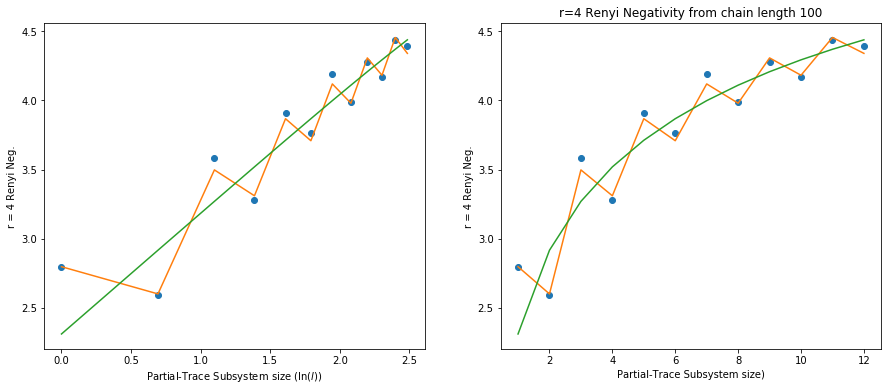

In [37]:
print('vmc: ', np.abs(Nr_vmc))
print('exact: ', np.abs(Nr_ex1))
print('error [%]:', np.abs(Nr_vmc-Nr_ex1)/np.abs(Nr_ex1)*100)

#N_vmc = np.abs(Nr_vmc)
#N_ex1 = np.abs(Nr_ex1)

fig = plt.figure(figsize=(15.0, 6.0))
axes1 = fig.add_subplot(1, 2, 1) 
axes2 = fig.add_subplot(1, 2, 2) 

axes1 = fig.add_subplot(1, 2, 1)
axes1.set_ylabel("r = %d Renyi Neg." %(r))
axes1.set_xlabel('Partial-Trace Subsystem size ($\ln{(l)}$)',fontsize=10)

axes2 = fig.add_subplot(1, 2, 2)
axes2.set_ylabel("r = %d Renyi Neg." %(r))
axes2.set_xlabel('Partial-Trace Subsystem size)',fontsize=10)

axes1.plot( np.log(Lsub_list/2), 3*N_vmc,'o')
axes1.plot(np.log(Lsub_list/2),3*N_ex1)
axes1.plot(np.log(Lsub_list/2),1.05 + ((1/2)*np.log(100*(np.sin(np.pi*Lsub_list/200))) + (3/8)*np.log(100*np.sin(2*np.pi*Lsub_list/200))))

plt.title('r=%d Renyi Negativity from chain length 100' % (r) )

axes2.plot( Lsub_list/2, 3*N_vmc,'o')
axes2.plot(Lsub_list/2,3*N_ex1)
axes2.plot(Lsub_list/2,1.05+((1/2)*np.log(100*(np.sin(np.pi*Lsub_list/200))) + (3/8)*np.log(100*np.sin(2*np.pi*Lsub_list/200))))


plt.show()

vmc:  [[1.0479071]
 [0.9938344]
 [1.3453072]
 [1.2241818]
 [1.4886652]
 [1.396219 ]
 [1.5845377]
 [1.4992361]
 [1.6349456]
 [1.5939465]
 [1.7014225]
 [1.6524569]]
exact:  [[0.9883851 ]
 [0.97496295]
 [1.2815492 ]
 [1.2395507 ]
 [1.4318547 ]
 [1.3892484 ]
 [1.5326821 ]
 [1.4919145 ]
 [1.6076921 ]
 [1.5688258 ]
 [1.6665761 ]
 [1.6293118 ]]
error [%]: [[6.02215  ]
 [1.9356045]
 [4.9750733]
 [1.2398798]
 [3.967616 ]
 [0.5017565]
 [3.3833294]
 [0.4907517]
 [1.6951945]
 [1.6012367]
 [2.0908918]
 [1.4205433]]


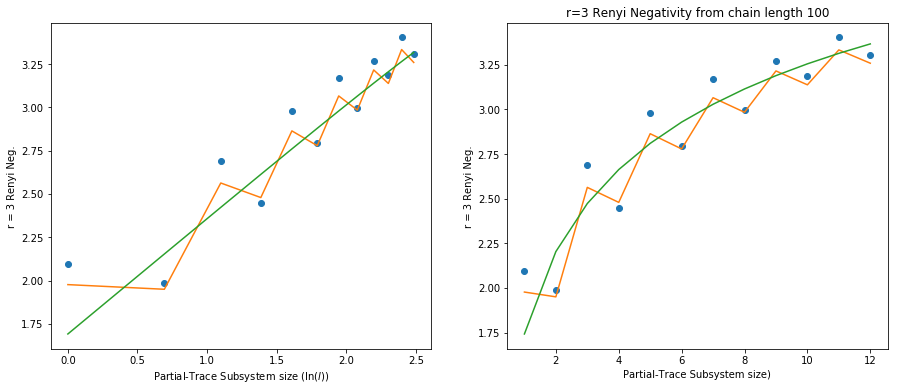

In [35]:
print('vmc: ', np.abs(Nr_vmc))
print('exact: ', np.abs(Nr_ex1))
print('error [%]:', np.abs(Nr_vmc-Nr_ex1)/np.abs(Nr_ex1)*100)

fig = plt.figure(figsize=(15.0, 6.0))
axes1 = fig.add_subplot(1, 2, 1) 
axes2 = fig.add_subplot(1, 2, 2) 

axes1 = fig.add_subplot(1, 2, 1)
axes1.set_ylabel("r = %d Renyi Neg." %(r))
axes1.set_xlabel('Partial-Trace Subsystem size ($\ln{(l)}$)',fontsize=10)

axes2 = fig.add_subplot(1, 2, 2)
axes2.set_ylabel("r = %d Renyi Neg." %(r))
axes2.set_xlabel('Partial-Trace Subsystem size)',fontsize=10)

axes1.plot( np.log(Lsub_list/2), 2*Nr_vmc,'o')
axes1.plot(np.log(Lsub_list/2),2*Nr_ex1)
axes1.plot(np.log(Lsub_list/2),0.775+(2/9)*(2*np.log(100*(np.sin(np.pi*Lsub_list/200))) + np.log(100*np.sin(2*np.pi*Lsub_list/200))))

plt.title('r=%d Renyi Negativity from chain length 100' % (r) )

axes2.plot( Lsub_list/2, 2*Nr_vmc,'o')
axes2.plot(Lsub_list/2,2*Nr_ex1)
axes2.plot(Lsub_list/2,0.825+(2/9)*(2*np.log(100*(np.sin(np.pi*Lsub_list/200))) + np.log(100*np.sin(2*np.pi*Lsub_list/200))))


plt.show()